# ScreenEC ratios' AUC analysis

### Imports and environment setup

- Date of run: 2025-05-27
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# import all functions from ../code/cohort_analysis_utils.py
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)

# Data loading and preprosessing

In [4]:
df = pd.read_csv('../data/screenec.csv', index_col=0, header=0, sep='\t')
df_samples = utils.normalize_column_names(df)
df['AGRIN'] = df['AGRN_ng/mg'].astype('float')
df['TIMP2'] = df['TIMP2_ng/mg'].astype('float')
df['NGAL'] = df['NGAL_ng/mg'].astype('float')
df['Endometrial_thickness'] = df['Grosor_endometrial'].astype('float')
df['Pathology'] = df['DX']

df = utils.cols_as_category(df, {'Pathology':{'non-EC': 0, 'EC': 1}})
df = df[['AGRIN', 'TIMP2', 'NGAL', 'Endometrial_thickness', 'Pathology']]
#df = df.dropna()

df['AGRIN_TIMP2'] = ((df['AGRIN'] + 1e-6) / (df['TIMP2'] + 1e-6)).apply(lambda x: np.log2(x) if x > 0 else np.nan)
df['NGAL_TIMP2'] = ((df['NGAL'] + 1e-6) / (df['TIMP2'] + 1e-6)).apply(lambda x: np.log2(x) if x > 0 else np.nan)
df['AGRIN_NGAL'] = ((df['AGRIN'] + 1e-6) / (df['NGAL'] + 1e-6)).apply(lambda x: np.log2(x) if x > 0 else np.nan)


In [5]:
BIOMARKERS = ['AGRIN_TIMP2', 'NGAL_TIMP2', 'AGRIN_NGAL', 'Endometrial_thickness']

# Model computation

In [6]:
RESULTS_PATH = f'../data/results/screenEC/'
apply_log = False
NORMALIZING_COL = '' 
VOLUME_COL = ''
METHODS = ['direct']

for biomarker_count in [1,2,3]:
    print(f'Number of biomarkers: {biomarker_count}')
    models = utils.compute_all_models_and_save(
                                df=df,
                                biomarkers=BIOMARKERS,
                                normalizing_col=NORMALIZING_COL, 
                                volume_col= VOLUME_COL,
                                volume_added=0.5,
                                apply_log=apply_log,
                                avoid_same_biomarker=True,
                                methods=METHODS,
                                max_biomarker_count=biomarker_count,
                                folder_name=RESULTS_PATH,
                                plot_rocs=True,
                                auc_threshold=0.4 + 0.1 * biomarker_count,
                                compute_auc_ci=True if biomarker_count == 1 else False,
                                )

    if biomarker_count == 1:
        # Reserve the models with confidence intervals for the final analysis
        models_with_auc_ci_1 = models
    
    
    
    print(f'Number of biomarkers: {biomarker_count} done')

Number of biomarkers: 1
Number of biomarkers: 1 done
Number of biomarkers: 2
Number of biomarkers: 2 done
Number of biomarkers: 3
Number of biomarkers: 3 done


## Number of observations per ratio & for ET

Having one of the values undefined, the ratio will be not computed, let's explore how many observations we have for each variable used in the models computation.

In [7]:
# Show the amount of samples without NaNs in each biomarker, per Pathology
for biomarker in BIOMARKERS:
    print(f'Biomarker: {biomarker}')
    print(df.groupby('Pathology')[biomarker].count())
    print('---')


Biomarker: AGRIN_TIMP2
Pathology
0    96
1    74
Name: AGRIN_TIMP2, dtype: int64
---
Biomarker: NGAL_TIMP2
Pathology
0    34
1    14
Name: NGAL_TIMP2, dtype: int64
---
Biomarker: AGRIN_NGAL
Pathology
0    33
1    14
Name: AGRIN_NGAL, dtype: int64
---
Biomarker: Endometrial_thickness
Pathology
0    93
1    70
Name: Endometrial_thickness, dtype: int64
---


## Confidence intervals for the univariate models

In [8]:
aucs = []
auc_cis = []
models = []
models_with_auc_ci = models_with_auc_ci_1
for model in models_with_auc_ci['direct'][(list(models_with_auc_ci['direct'].keys())[0])].keys():
    model_name = model[0]
    model_auc = models_with_auc_ci['direct'][(list(models_with_auc_ci['direct'].keys())[0])][model]['auc']
    model_auc_ci = models_with_auc_ci['direct'][(list(models_with_auc_ci['direct'].keys())[0])][model]['auc_ci']
    aucs.append(float(model_auc))
    auc_cis.append([float(model_auc_ci[0]), float(model_auc_ci[1])])
    models.append(model_name)

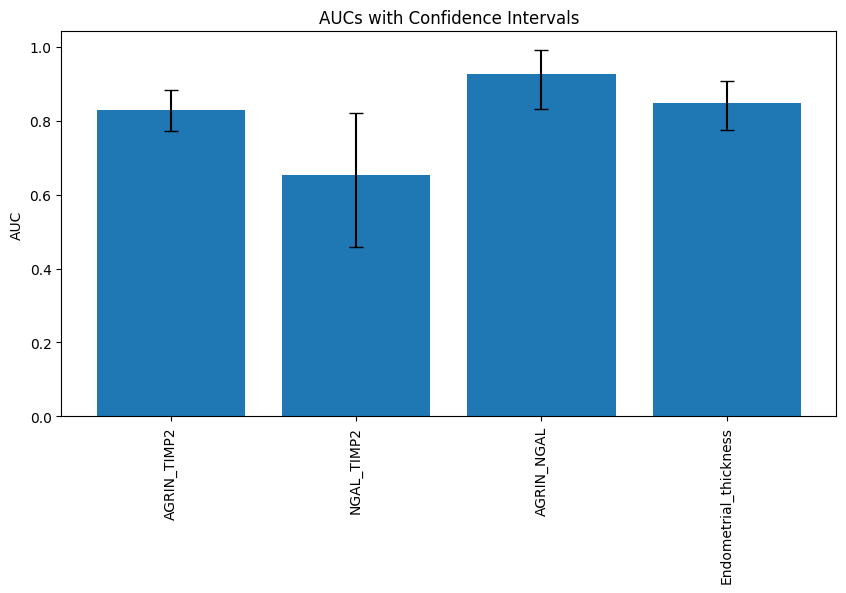

In [9]:
auc_cis = np.array(auc_cis)

# Calculate the errors
lower_err = aucs - auc_cis[:, 0]
upper_err = auc_cis[:, 1] - aucs
yerr = [lower_err, upper_err]

plt.figure(figsize=(10,5))
plt.bar(models, aucs, yerr=yerr, capsize=5, align='center')
plt.xticks(rotation=90)
plt.ylabel('AUC')
plt.title('AUCs with Confidence Intervals')
plt.show()

## Overlap with Cohort 7.3 samples

In [10]:
df_7_3 = pd.read_csv('../data/cohort_7.3_20250527.csv', sep='\t', index_col=0, header=0)

In [13]:
cohort_7_3_codes = set(df_7_3.index)

In [15]:
df_reloaded = pd.read_csv('../data/screenec.csv', index_col=0, header=0, sep='\t')
screenec_codes = set(df_reloaded.index).union(set(df_reloaded['Other Ids'].values))

In [16]:
cohort_7_3_codes.intersection(screenec_codes)

{'001-0010',
 '001-0022',
 '001-0025',
 '001-0035',
 '001-0095',
 '001-0109',
 '001-0112',
 '002-0002',
 '002-0007',
 '002-0038'}

# Nuevas cosas a computar

- Para las cohortes 240 (6), 7.1, 7.2, 7.3 buscar codigo paciente, codigo redcap, codigo masas, si es que hay, y hacer la intersección.
- Así como le pasé el resumen de la 7.1, conseguir el summary 7.1 para que ella mapee sample con patient.
- Pasar codigos de la cohorte 6.


## Cohorte MS 215

PATIENTS:

510,640,651,791,800,820,829,868,794,801,817,816,812,807,804,744,722,848,527,153,302,594,628,766,823,85 F,521,815,741,
844,157,102 F,629,846,637,393,5 F,877,871,851,810,797,724,623,439,364,314,313,309,271,881,752,660,20 F,619,830,51 F,
75 F,638,563,762,873,780,62 F,782,220,328,350,360,367,379,381,382,388,642,809,856,860,505,530,658,90 F,883,882,875,874,
818,827,764,770,803,828,840,248,122,128,188,872,870,850,847,845,843,842,841,838,837,836,833,28 F,56 F,64 F,70 F,74 F,
80 F,82 F,86 F,91 F,48 F,68 F,72 F,73 F,93 F,239,761,763,767,779,793,799,802,821,822,824,825,593,788,869,77 F,290,403,
408,451,453,590,636,798,832,834,876,100 F,103 F,105 F,247,356,747,749,776,796,880,44,278,634,750,795,15 F,89 F,746,743,
730,721,720,656,755,622,617,609,517,484,466,465,376,333,87 F,790,772,202,632,139,88 F,500,737,499,429,458,402,547,76 F,
194,104 F,255,777,819,655,753,650,644,599,571,544,771,852,219,217,751


### Cohorte 67 ExoMark:

CodePatient:

382,361,388,381,386,392,161,67A,372,368,42A,385,366,377,354,371,374,384,562,334,375,95A,306,391,390,556,153,256,505,
445,228,195,270,159,431,222,185,532,460,561,204,456,464,524,545,508,418,S5,S7,284,597,548,563,591,S2,507,S1,S8,595,596,
S3,592,S4,167,469,S6,514

### Cohorte 6 (240 patients, dilution 1:1)

Samples/patients: 

361,407,386,1082,1035,425,389,544,1195,381,148,420,891,895,219,328,1097,1015,571,941,870,360,1143,1108,1298,
1042,1067,1052,1374,798,388,378,438,1079,410,890,309,226,220,1165,1358,1091,1153,551,1092,409,1266,1343,1260,1278,1070,
428,242,829,1113,1259,230,1094,1381,1349,426,1096,LL81,LL127,812,885,868,433,956,962,1010,1053,1105,HGC14,1254,379,
1331,1302,1202,901,1451,1377,1244,LL64,1074,1357,1223,54,1127,LL36,1280,356,ICO4,53,1250,424,1027,971,923,1072,989,
1231,986,1023,830,1446,1186,LL112,HGC18,940,788,780,1482,1051,484,1071,995,1061,629,1068,1044,1086,1047,934,40,382,
1145,1277,1245,LL114,1125,LL116,46,834,952,959,1308,837,1136,825,902,417,980,984,1347,619,HGC10,1121,563,823,LL85,1033,
1215,771,782,ICO12,1304,1009,1288,1056,1295,900,655,LL18,936,1077,1021,586,819,634,888,1011,LL124,1276,1058,628,1385,
876,259,1283,990,1248,1087,872,496,827,1085,1002,1242,1129,603,1332,519,1106,1049,894,731,149,1110,1069,831,593,1102,
1185,869,1453,594,1388,445,1436,725,1005,892,1329,765,973,1173,1181,964,1135,808,856,1399,1124,1081,1258,1012,1397,
ICO7,762,561,1336,632,ICO27,1112,LL87,1147,1115,1197,1078,ICO73,LL14,1491,638,929,1249,1216,ICO30,1017,966


### Cohorte 7.1 (60x60 enlarged, +0.5mL)

Samples:

001-0004,001-0005,001-0006,001-0007,001-0008,001-0009,001-0011,001-0012,001-0013,001-0014,001-0017,001-0019,001-0024,
001-0025,001-0034,001-0040,002-0001,002-0002,002-0004,002-0005,002-0006,002-0007,002-0008,002-0012,002-0013,002-0015,
002-0016,002-0018,002-0019,002-0020,002-0022,002-0023,002-0024,002-0025,002-0026,002-0027,002-0028,003-0002,003-0007,
003-0011,003-0012,003-0013,003-0028,003-0030,003-0035,003-0039,003-0043,003-0044,003-0047,003-0049,003-0050,003-0062,
004-0001,004-0003,004-0006,004-0008,004-0009,005-0003,005-0004,005-0007,005-0008,006-0001,006-0009,007-0002,007-0004,
007-0006,007-0009,007-0010,007-0011,007-0012,007-0013,008-0034,008-0035,010-0007,010-0012,011-0002,011-0032,012-0001,
012-0002,012-0003,012-0005,012-0007,012-0008,012-0009,012-0012,012-0013,012-0014,012-0015,012-0016,012-0018,012-0023,
012-0025,012-0026,012-0027,012-0028,012-0029,012-0030,013-0003,013-0006,014-0026,016-0033,016-0043,018-0001,018-0002,
018-0006,018-0016,020-0001,020-0002,020-0004,020-0006,020-0007,020-0008,020-0014,020-0015,020-0023,020-0034,020-0037,
020-0047,020-0049,020-0050,001-0063,003-0005,003-0006,003-0009,003-0021,003-0022,003-0051,003-0056,003-0064,003-0065,
003-0067,003-0070,003-0082,003-0086,003-0088,003-0090,003-0092,004-0007,005-0009,005-0012,006-0020,006-0030,006-0031,
006-0037,006-0045,009-0026,013-0047,014-0024,015-0023,015-0048,015-0049,020-0077


### Cohorte 7.2 (+2mL)

Samples:

003-0123,003-0143,003-0162,009-0021,009-0083,009-0084,002-0053,002-0054,002-0056,002-0055,003-0076,024-0005,009-0097,
003-0155,003-0165,011-0071,002-0058,003-0168,003-0170,006-0050,006-0101,006-0103,006-0104,006-0105,006-0106,002-0059,
006-0110,012-0217,002-0060,008-0016,008-0018,008-0039,011-0068,002-0061,011-0069,002-0064,011-0081,003-0124,012-0205,
012-0207,003-0135,012-0208,012-0209,012-0211,012-0212,012-0213,003-0138,003-0151,003-0156,012-0214,003-0161,012-0216,
012-0220,003-0163,012-0221,012-0223,012-0224,003-0166,002-0057,012-0231,012-0232,012-0233,012-0225,012-0234,012-0235,
003-0167,012-0236,012-0237,012-0238,006-0108,012-0240,006-0109,012-0241,007-0022,012-0226,012-0242,007-0023,007-0024,
012-0227,008-0038,012-0243,011-0015,011-0016,006-0107,012-0230,024-0008,024-0009,011-0017,011-0018,011-0021,012-0244,
037-0004,011-0022,011-0099,012-0245,012-0246,012-0247,012-0215,012-0249,012-0250,012-0219,012-0222,012-0253,012-0254,
012-0228,012-0256,012-0229,012-0239,024-0027,037-0005,012-0248,030-0022,012-0251,012-0252,012-0255,024-0011


### Cohorte 7.3 ("pure")

Sample:

001-0004,001-0005,001-0006,001-0007,001-0008,001-0009,001-0011,001-0012,001-0013,001-0014,001-0017,001-0019,
001-0024,001-0025,001-0034,001-0040,002-0001,002-0002,002-0004,002-0005,002-0006,002-0007,002-0008,002-0012,
002-0013,002-0015,002-0016,002-0018,002-0019,002-0020,002-0022,002-0023,002-0024,002-0025,002-0026,002-0027,
002-0028,003-0002,003-0007,003-0011,003-0012,003-0013,003-0028,003-0030,003-0035,003-0039,003-0043,003-0044,
003-0047,003-0049,003-0050,003-0062,004-0001,004-0003,004-0006,004-0008,004-0009,005-0003,005-0004,005-0007,
005-0008,006-0001,006-0009,007-0002,007-0004,007-0006,007-0009,007-0010,007-0011,007-0012,007-0013,008-0034,
008-0035,010-0007,010-0012,011-0002,011-0032,012-0001,012-0002,012-0003,012-0005,012-0007,012-0008,012-0009,
012-0012,012-0013,012-0014,012-0015,012-0016,012-0018,012-0023,012-0025,012-0026,012-0027,012-0028,012-0029,
012-0030,013-0003,013-0006,014-0026,016-0033,016-0043,018-0001,018-0002,018-0006,018-0016,020-0001,020-0002,
020-0004,020-0006,020-0007,020-0008,020-0014,020-0015,020-0023,020-0034,020-0037,020-0047,020-0049,020-0050,
001-0063,003-0005,003-0006,003-0009,003-0021,003-0022,003-0051,003-0056,003-0064,003-0065,003-0067,003-0070,
003-0082,003-0086,003-0088,003-0090,003-0092,004-0007,005-0009,005-0012,006-0020,006-0030,006-0031,006-0037,
006-0045,009-0026,013-0047,014-0024,015-0023,015-0048,015-0049,020-0077
